Remotely susbet CMEMS Arctic Ocean Physics Reanalysis dataset

In [1]:
import copernicusmarine
import geopandas as gpd
import pyproj
import shapely
import xarray as xr

# Requires Copernicus Marine account: https://data.marine.copernicus.eu/register
copernicusmarine.login(skip_if_user_logged_in=True)

# Get subset bounds by buffering combined bbox of sampling points
sample_points = gpd.read_file("../data/ocean/ocean_sample_points.geojson")
sample_bbox = gpd.GeoSeries(shapely.geometry.box(*sample_points.total_bounds)).set_crs(3413)
sample_bbox = sample_bbox.buffer(50_000, cap_style="square", join_style="mitre").to_crs(4326)
x_min, y_min, x_max, y_max = sample_bbox.total_bounds

# Remotely access TOPAZ ocean potential temperature data
topaz_ds = copernicusmarine.open_dataset(
    dataset_id="cmems_mod_arc_phy_my_topaz4_P1M",
    dataset_version="202012",
    variables=["thetao"],
    minimum_latitude=y_min,
    minimum_longitude=x_min,
    maximum_latitude=y_max,
    maximum_longitude=x_max,
    start_datetime="2000-01-01T00:00:00",
    end_datetime="2024-01-01T00:00:00",
    minimum_depth=0,
    maximum_depth=500,
)

INFO - 2024-08-06T21:26:45Z - You are already logged in. Skipping login.
INFO - 2024-08-06T21:26:45Z - You forced selection of dataset version "202012"
INFO - 2024-08-06T21:26:45Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-06T21:26:47Z - Service was not specified, the default one was selected: "arco-time-series"
WARNING - 2024-08-06T21:26:49Z - Some or all of your subset selection [2000-01-01 00:00:00, 2024-01-01 00:00:00] for the time dimension  exceed the dataset coordinates [1991-01-01 00:00:00, 2023-12-01 00:00:00]


Sample TOPAZ ocean potential temperature

In [2]:
# To store sampled Datasets
ocean_ds = []

# Group sampling points by corresponding glacier
for glacier, point in sample_points.groupby(by="glacier"):
    # Construct 50x50km sampling box around point
    x = point.geometry.x.item()
    y = point.geometry.y.item()
    transformer = pyproj.Transformer.from_crs("EPSG:3413", "EPSG:4326")
    x_min, y_min = transformer.transform(x - 25000, y - 25000)
    x_max, y_max = transformer.transform(x + 25000, y + 25000)
    x_slice = slice(x_min, x_max)
    y_slice = slice(y_min, y_max)

    # Subset reanalysis dataset by sampling box
    temperature_ds = topaz_ds.sel(latitude=x_slice, longitude=y_slice)

    # Sample ocean potential temperature by taking median value of 50km sampling box
    temperature_ds["thetao"] = temperature_ds.thetao.median(dim=["latitude", "longitude"]).assign_attrs(
        temperature_ds.thetao.attrs
    )
    temperature_ds = temperature_ds.rename(thetao="temperature")

    # Calculate baseline average and time series anomalies
    temperature = temperature_ds.temperature
    temperature_baseline = temperature_ds.temperature.groupby("time.month").mean()
    temperature_anomaly = temperature.groupby("time.month") - temperature_baseline

    # Store anomalies as new variable
    temperature_ds = temperature_ds.assign(temperature_anomaly=temperature_anomaly.drop_vars("month"))

    # Assign dimensions of current point and swap lat/lon for projected coords of sampling point
    temperature_ds = temperature_ds.drop_dims(drop_dims=["latitude", "longitude"])
    temperature_ds = temperature_ds.expand_dims(dim="glacier")
    temperature_ds = temperature_ds.assign_coords(
        glacier=("glacier", [glacier]),
        x=(("glacier"), [x]),
        y=(("glacier"), [y]),
    )
    ocean_ds.append(temperature_ds)


# Concat sampled Datasets and write to disk
ocean_ds = xr.combine_by_coords(ocean_ds, combine_attrs="drop_conflicts")
ocean_ds.to_netcdf("../data/ocean/ocean.nc")
ocean_ds

<xarray.Dataset> Size: 122kB
Dimensions:              (glacier: 2, time: 288, depth: 26)
Coordinates:
  * depth                (depth) float32 104B 0.0 2.0 4.0 ... 400.0 450.0 500.0
  * time                 (time) datetime64[ns] 2kB 2000-01-01 ... 2023-12-01
  * glacier              (glacier) <U24 192B 'DAUGAARD-JENSEN' 'UNNAMED_UUNAR...
    x                    (glacier) float64 16B 8.909e+05 5.695e+05
    y                    (glacier) float64 16B -1.991e+06 -2.428e+06
Data variables:
    temperature          (glacier, time, depth) float32 60kB -1.84 ... nan
    temperature_anomaly  (glacier, time, depth) float32 60kB -0.004874 ... nan
Attributes:
    Conventions:  CF-1.4
    field_date:   1991-01-15
    field_type:   Files based on file type nersc_weekly
    history:      20220830:Created by program hyc2proj, version V0.3
    institution:  NERSC, Jahnebakken 3, N-5007 Bergen, Norway
    references:   http://topaz.nersc.no
    source:       NERSC-HYCOM model fields
    title:        Arctic Ocean Physics Reanalysis
    version:      v4b

Ocean temperature time series at Uunartit Islands (blue=surface, red=deep)

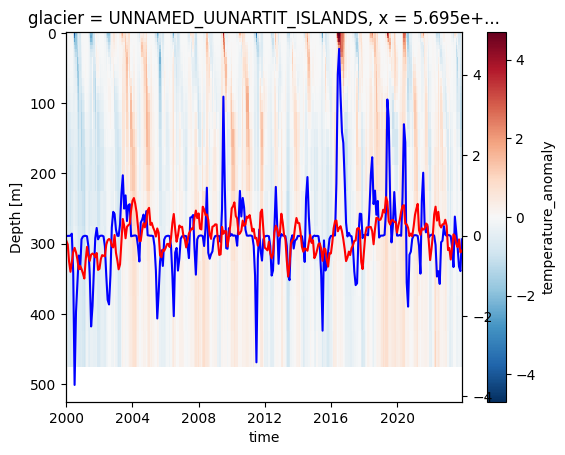

In [23]:
ax_pcolormesh = ocean_ds.isel(glacier=1).temperature_anomaly.plot(x="time")
ax_pcolormesh.axes.invert_yaxis()
ax_lines = ax_pcolormesh.axes.twinx()
ocean_ds.isel(glacier=1).temperature_anomaly.sel(depth=slice(2, 6)).mean("depth").plot(
    ax=ax_lines, color="blue", _labels=False
)
ocean_ds.isel(glacier=1).temperature_anomaly.sel(depth=slice(200, 400)).mean("depth").plot(
    ax=ax_lines, color="red", _labels=False
)

Linear trend

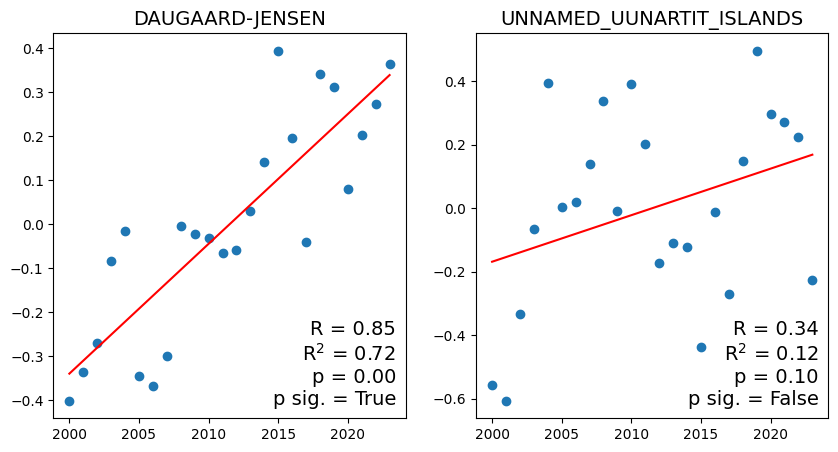

In [4]:
import matplotlib.pyplot as plt
import scipy
import xarray as xr
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

# Set up axes
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(nrows=1, ncols=2, width_ratios=(1, 1))
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
axs = [ax0, ax1]

# Load sampled ocean temperature data
ocean_ds = xr.open_dataset("../data/ocean/ocean.nc")

for i, (glacier, ds) in enumerate(ocean_ds.groupby("glacier", squeeze=False)):
    # temperature = ds.sel(depth=slice(2, 6)).mean(dim="depth").squeeze()
    temperature = ds.sel(depth=slice(200, 400)).mean(dim="depth").squeeze()

    temperature = temperature.temperature_anomaly.resample(time="1YS").mean()
    years = temperature.time.dt.year

    mask = temperature.notnull() & years.notnull()
    temperature = temperature.where(mask, drop=True)
    years = years.where(mask, drop=True)

    # Regress terminus change against year
    res = scipy.stats.linregress(years, temperature)

    # Plot data and trendline
    axs[i].plot(years, temperature, "o")
    axs[i].plot(years, res.intercept + res.slope * years, "r", label="fitted line")

    # Add R2 and p values to plot
    axs[i].add_artist(
        AnchoredText(
            f"R = {res.rvalue:.2f}\nR$^{{2}}$ = {res.rvalue**2:.2f}\np = {res.pvalue:.2f}\np sig. = {res.pvalue < 0.05}",
            loc="lower right",
            borderpad=0.1,
            prop=dict(fontsize=14, horizontalalignment="right"),
            frameon=False,
        )
    )

    # Label plots
    axs[i].set_title(glacier, fontsize=14)

plt.show()